In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import regex as re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from gensim.models import Word2Vec


import warnings 
warnings.filterwarnings(action = 'ignore')

In [2]:
# reading in csv and checking hed
reddit = pd.read_csv('reddit_comments.csv', index_col=0)

reddit.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [3]:
# verifying shape
reddit.shape

(1010714, 2)

In [4]:
# custom tokenizer function

def tokenizer(series):
    # get values from series
    corpus = series.values
    tokens = [] # empty token list
    
    for document in corpus:
        #removing punctuation
        for punc in string.punctuation:
            document = document.replace(punc, '')
        
        # removing numbers and setting all documents to lowercase    
        document = re.sub("\d+", "", document).lower()
        # splitting documents and appending tokens list
        tokens.append(document.split(' '))
        
    
        

    return tokens

In [5]:
# setting X and y
X = reddit['comment']
y = reddit['label']

In [6]:
# tokenizing comments through custom fucntion
tokenized_data = tokenizer(X)

In [7]:
# training word2vec model 
embeddings = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=10000 )
embeddings.train(tokenized_data, total_examples=model.corpus_count, epochs=model.epochs)

(32243460, 52702745)

In [9]:
# function to vectorize documents
def sentence(document):
    
    size = embeddings.vector_size # setting constant document size
    word_vec_doc = np.zeros(size) # populating list of document size with zeros 
    count = 1 # word count to be used for average
    
    # looping through documents
    for word in document:
        # checking if word exists in document
        if word in embeddings:
            count +=1
            word_vec_doc += embeddings[word] # adding word embedding to doc embedding
    
    word_vec_doc = word_vec_doc / count # taking average of embeddings
    
    return word_vec_doc

In [10]:
# setting vectors to variable
document_vectors = [sentence(doc) for doc in tokenized_data]

In [11]:
# setting X to be document vectors
X = document_vectors

In [12]:

# initial split into rem and test
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
# secondary split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [14]:
from sklearn.neural_network import MLPClassifier

# instantiating mlp classifier, setting max iter to 100
MLP = MLPClassifier(verbose=True, max_iter=100, random_state=42)

# fitting to train
MLP.fit(X_train, y_train)

Iteration 1, loss = 0.59881552
Iteration 2, loss = 0.57961249
Iteration 3, loss = 0.57239086
Iteration 4, loss = 0.56768677
Iteration 5, loss = 0.56386962
Iteration 6, loss = 0.56104931
Iteration 7, loss = 0.55850151
Iteration 8, loss = 0.55627233
Iteration 9, loss = 0.55432540
Iteration 10, loss = 0.55247128
Iteration 11, loss = 0.55105432
Iteration 12, loss = 0.54974282
Iteration 13, loss = 0.54833995
Iteration 14, loss = 0.54711141
Iteration 15, loss = 0.54609561
Iteration 16, loss = 0.54510941
Iteration 17, loss = 0.54422463
Iteration 18, loss = 0.54311705
Iteration 19, loss = 0.54240122
Iteration 20, loss = 0.54168748
Iteration 21, loss = 0.54117603
Iteration 22, loss = 0.54003264
Iteration 23, loss = 0.53947314
Iteration 24, loss = 0.53882382
Iteration 25, loss = 0.53819011
Iteration 26, loss = 0.53762987
Iteration 27, loss = 0.53705778
Iteration 28, loss = 0.53648932
Iteration 29, loss = 0.53627032
Iteration 30, loss = 0.53559124
Iteration 31, loss = 0.53515436
Iteration 32, los

MLPClassifier(max_iter=100, random_state=42, verbose=True)

In [26]:
# printing resulting train and val scores
print(f'Train: {MLP.score(X_train, y_train)}')
print(f'Val: {MLP.score(X_val, y_val)}')

Train: 0.7441770473118204
Val: 0.6959458389839005


In [25]:
# setting predictions to variable
val_predict = MLP.predict(X_val)

In [26]:
# instantiating and printing classification report
report = classification_report(y_val, val_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(report)


               precision    recall  f1-score   support

Non-Sarcastic       0.68      0.74      0.71     94698
    Sarcastic       0.72      0.66      0.69     94811

     accuracy                           0.70    189509
    macro avg       0.70      0.70      0.70    189509
 weighted avg       0.70      0.70      0.70    189509



In [21]:
# reinstantiating more precise word2vec 
embeddings = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=25000 )
embeddings.train(tokenized_data, total_examples=model.corpus_count, epochs=model.epochs)


(36950638, 52702745)

In [22]:
# setting new x to new vectors
new_vectors = [sentence(doc) for doc in tokenized_data]
new_X = new_vectors

In [23]:
# performing new train/test split
X_rem, X_test, y_rem, y_test = train_test_split(new_X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [24]:
 # running mlp classifier again with max iter at 50
MLP = MLPClassifier(verbose=True, max_iter=50, random_state=42)

# fitting to new x train
MLP.fit(X_train, y_train)

Iteration 1, loss = 0.59881552
Iteration 2, loss = 0.57961249
Iteration 3, loss = 0.57239086
Iteration 4, loss = 0.56768677
Iteration 5, loss = 0.56386962
Iteration 6, loss = 0.56104931
Iteration 7, loss = 0.55850151
Iteration 8, loss = 0.55627233
Iteration 9, loss = 0.55432540
Iteration 10, loss = 0.55247128
Iteration 11, loss = 0.55105432
Iteration 12, loss = 0.54974282
Iteration 13, loss = 0.54833995
Iteration 14, loss = 0.54711141
Iteration 15, loss = 0.54609561
Iteration 16, loss = 0.54510941
Iteration 17, loss = 0.54422463
Iteration 18, loss = 0.54311705
Iteration 19, loss = 0.54240122
Iteration 20, loss = 0.54168748
Iteration 21, loss = 0.54117603
Iteration 22, loss = 0.54003264
Iteration 23, loss = 0.53947314
Iteration 24, loss = 0.53882382
Iteration 25, loss = 0.53819011
Iteration 26, loss = 0.53762987
Iteration 27, loss = 0.53705778
Iteration 28, loss = 0.53648932
Iteration 29, loss = 0.53627032
Iteration 30, loss = 0.53559124
Iteration 31, loss = 0.53515436
Iteration 32, los

MLPClassifier(max_iter=50, random_state=42, verbose=True)

In [27]:
print(f'Train: {MLP.score(X_train, y_train)}')
print(f'Val: {MLP.score(X_val, y_val)}')

Train: 0.7386469572191949
Val: 0.700061738492631


In [28]:
new_val_predict = MLP.predict(X_val)

In [29]:
new_report = classification_report(y_val, new_val_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(new_report)

               precision    recall  f1-score   support

Non-Sarcastic       0.68      0.74      0.71     94698
    Sarcastic       0.72      0.66      0.69     94811

     accuracy                           0.70    189509
    macro avg       0.70      0.70      0.70    189509
 weighted avg       0.70      0.70      0.70    189509



In [30]:
new_probas = MLP.predict_proba(X_val)

In [35]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [36]:
# Varying thresholds by 0.05 between 0.05 & 1
thresholds = np.arange(0.05, 1, 0.05)

# empty precision/recall lists
precisions = []
recalls = []

# looping through threshold range
for threshold in thresholds:

    # Applying threshold
    y_threshold = np.where(new_probas > threshold, 1, 0)
    
    # Calculating precision and recall
    precision = precision_score(y_val, y_threshold)
    recall = recall_score(y_val, y_threshold)
    
    # Appending to lists
    precisions.append(precision)
    recalls.append(recall)



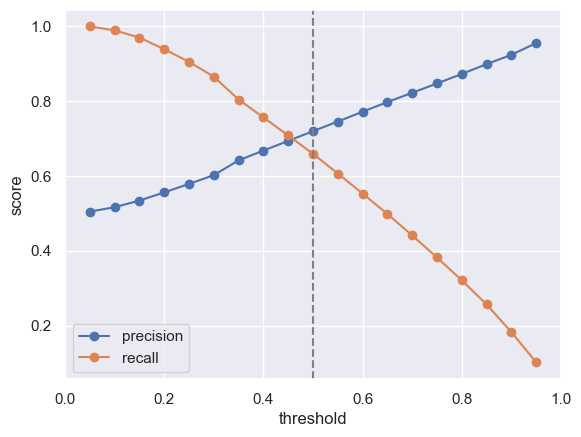

In [37]:
# Visualizing the result
plt.figure()

plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')

plt.xlim(0, 1)
plt.axvline(np.median(thresholds), linestyle='--', color='gray')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()

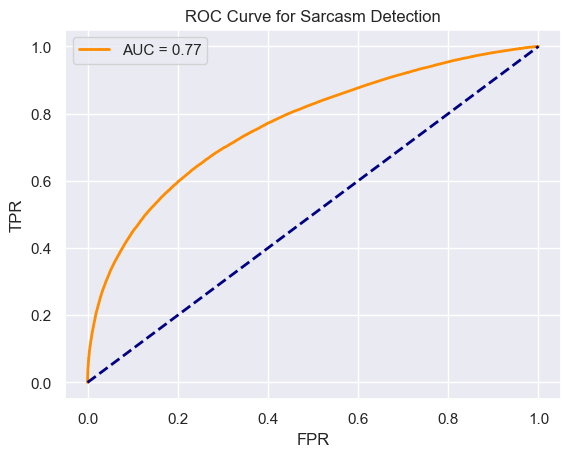

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_val, new_probas)
roc_auc = roc_auc_score(y_val, new_probas)


plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Sarcasm Detection')
plt.legend(loc="best")
plt.show()



In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = MLP.predict(X_val)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,70619,24079
True Positive,28736,66075


In [61]:


ConfusionMatrixDisplay.from_estimator(MLP, X_val, y_val);



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [39]:
def test_tokenizer(document):
    
    
    # replacing punctuation with empty string
    for punc in string.punctuation:
        document = document.replace(punc, '')
        
        # removing numbers and setting all documents to lowercase    
    document = re.sub("\d+", "", document).lower()
    
        # splitting documents and appending tokens list
    tokens = document.split(' ')
        
    
        

    return tokens

In [40]:
def vectorizer(document):

    tokens = test_tokenizer(document) # calling tokenizer function
    two_d_vec = [] # empty list to make list 2d
    
    size = embeddings.vector_size # setting constant document size
    word_vec_doc = np.zeros(size) # populating list of document size with zeros 
    count = 1 # word count to be used for average
    
    # looping through documents
    for word in document:
        # checking if word exists in document
        if word in embeddings:
            count +=1
            word_vec_doc += embeddings[word] # adding word embedding to doc embedding
    
    word_vec_doc = word_vec_doc / count # taking average of embeddings
    
    # appending to empty list to make 2d
    two_d_vec.append(word_vec_doc)
    
    return two_d_vec

In [41]:
# test document to run through function
document1 = "This is simply a test. Can I call a function within a function?"

# function test
vekt_doc = vectorizer(document1)

In [42]:
# printing result
result = MLP.predict_proba(vekt_doc)[0][1]
print(f'Result: {round(result, 2)}')

Result: 0.12


In [43]:
sentence1 = "Fair and logical."
sentence2 = "He said no. Fair and logical."
sentence3 = "He said no. That's fair and logical."

sentence4 = "He said no. Very fair and logical"
sentence5 = "He said no. Very fair and very logical."

sentence6 = "He said no. Seems fair and logical to me."



In [44]:
doc1 = vectorizer(sentence1)
doc2 = vectorizer(sentence2)
doc3 = vectorizer(sentence3)
doc4 = vectorizer(sentence4)
doc5 = vectorizer(sentence5)
doc6 = vectorizer(sentence6)

In [45]:
proba1 = round(MLP.predict_proba(doc1)[0][1], 2)
proba2 = round(MLP.predict_proba(doc2)[0][1], 2)
proba3 = round(MLP.predict_proba(doc3)[0][1], 2)
proba4 = round(MLP.predict_proba(doc4)[0][1], 2)
proba5 = round(MLP.predict_proba(doc4)[0][1], 2)
proba6 = round(MLP.predict_proba(doc4)[0][1], 2)


In [46]:
print('PROBABILITY SARCASTIC: \n')
print(f'Sentence1: {proba1} \n Sentence2: {proba2} \n Sentence3: {proba3} \n')
print(f'Sentence4: {proba4} \n Sentence5: {proba5} \n ')
print(f'Sentence6: {proba6}')

PROBABILITY SARCASTIC: 

Sentence1: 0.27 
 Sentence2: 0.72 
 Sentence3: 0.63 

Sentence4: 0.8 
 Sentence5: 0.8 
 
Sentence6: 0.8


In [50]:
MLP = MLPClassifier(verbose=True, max_iter=50, random_state=42, early_stopping=True, validation_fraction=0.25)

history = MLP.fit(X_rem, y_rem)

Iteration 1, loss = 0.59937341
Validation score: 0.686928
Iteration 2, loss = 0.58032241
Validation score: 0.694157
Iteration 3, loss = 0.57304494
Validation score: 0.694716
Iteration 4, loss = 0.56810440
Validation score: 0.697692
Iteration 5, loss = 0.56449148
Validation score: 0.696273
Iteration 6, loss = 0.56135184
Validation score: 0.700531
Iteration 7, loss = 0.55879218
Validation score: 0.700273
Iteration 8, loss = 0.55668974
Validation score: 0.700457
Iteration 9, loss = 0.55487976
Validation score: 0.700959
Iteration 10, loss = 0.55301342
Validation score: 0.700574
Iteration 11, loss = 0.55163110
Validation score: 0.700927
Iteration 12, loss = 0.55025720
Validation score: 0.701428
Iteration 13, loss = 0.54904782
Validation score: 0.702109
Iteration 14, loss = 0.54774852
Validation score: 0.700299
Iteration 15, loss = 0.54654502
Validation score: 0.702019
Iteration 16, loss = 0.54544972
Validation score: 0.701418
Iteration 17, loss = 0.54471944
Validation score: 0.702384
Iterat

In [59]:
model.most_similar('honest')

[('fair', 0.5444294214248657),
 ('happy', 0.4073795676231384),
 ('pretend', 0.39431893825531006),
 ('accurate', 0.3941076993942261),
 ('objective', 0.391853392124176),
 ('consistent', 0.39180988073349),
 ('careful', 0.39105141162872314),
 ('helpful', 0.37912407517433167),
 ('worried', 0.3685811460018158),
 ('unbiased', 0.36201316118240356)]